In [36]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
plt.style.use('default')

import seaborn as sns
from tqdm import tqdm
import tensorflow as tf

%matplotlib inline

In [37]:
df = pd.read_parquet('./data/1s/train_test_data.parquet')
df.head()

,Frequencia CMB,CV-1,PT-1,PT-2,PT-3
0,40.0,0.547607,-0.980835,6.745117,4.180664
1,40.0,0.569545,-0.980748,6.782366,4.125000
2,40.0,0.588588,-0.973145,6.764509,4.208705
3,40.0,0.559163,-0.969645,6.798177,4.164713
4,40.0,0.570940,-0.978655,6.791295,4.159598


In [38]:
n_anteriores = 4
n_posteriores = 2

for i in range(1,n_anteriores+1):
    df[f'PT-1(K-{i})'] = df['PT-1'].shift(i)
    df[f'PT-2(K-{i})'] = df['PT-2'].shift(i)
    df[f'PT-3(K-{i})'] = df['PT-3'].shift(i)
    
for i in range(-1,-(n_posteriores+1),-1):
    df[f'PT-1(K+{-i})'] = df['PT-1'].shift(i)
    df[f'PT-2(K+{-i})'] = df['PT-2'].shift(i)
    df[f'PT-3(K+{-i})'] = df['PT-3'].shift(i)

df.columns

Index(['Frequencia CMB', 'CV-1', 'PT-1', 'PT-2', 'PT-3', 'PT-1(K-1)',
       'PT-2(K-1)', 'PT-3(K-1)', 'PT-1(K-2)', 'PT-2(K-2)', 'PT-3(K-2)',
       'PT-1(K-3)', 'PT-2(K-3)', 'PT-3(K-3)', 'PT-1(K-4)', 'PT-2(K-4)',
       'PT-3(K-4)', 'PT-1(K+1)', 'PT-2(K+1)', 'PT-3(K+1)', 'PT-1(K+2)',
       'PT-2(K+2)', 'PT-3(K+2)'],
      dtype='object')

In [39]:
df.isnull().sum()

Frequencia CMB    0
CV-1              0
PT-1              0
PT-2              0
PT-3              0
PT-1(K-1)         1
PT-2(K-1)         1
PT-3(K-1)         1
PT-1(K-2)         2
PT-2(K-2)         2
PT-3(K-2)         2
PT-1(K-3)         3
PT-2(K-3)         3
PT-3(K-3)         3
PT-1(K-4)         4
PT-2(K-4)         4
PT-3(K-4)         4
PT-1(K+1)         1
PT-2(K+1)         1
PT-3(K+1)         1
PT-1(K+2)         2
PT-2(K+2)         2
PT-3(K+2)         2
dtype: int64

In [40]:
df.dropna(inplace=True)

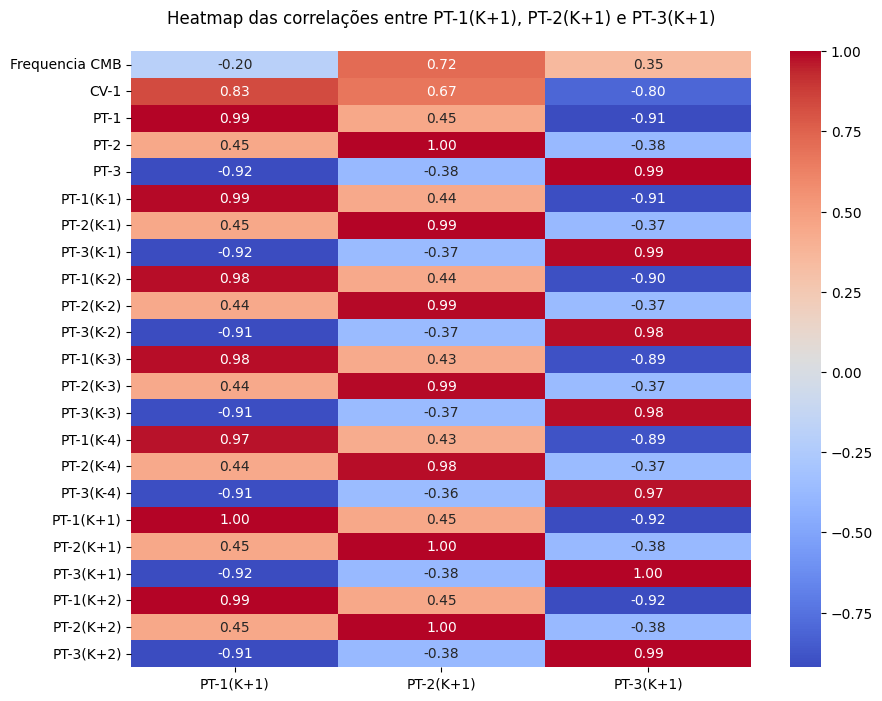

In [41]:
cols = ['PT-1(K+1)', 'PT-2(K+1)', 'PT-3(K+1)']
corr = df.corr()
plt.figure(figsize=(10, 8))
heatmap = sns.heatmap(corr[cols], annot=True, cmap='coolwarm', fmt=".2f")
heatmap.set_title('Heatmap das correlações entre PT-1(K+1), PT-2(K+1) e PT-3(K+1)', pad=20)
plt.show()

In [42]:
#Normalizando
data = tf.keras.utils.normalize(np.array(df), axis=1)
nor = np.linalg.norm(df, axis=1, keepdims=True)

In [43]:
from sklearn.model_selection import train_test_split

# Separando os dados em X e y
X = data[:, 0:17]
y = data[:, 17:]

X_train, X_test, y_train, y_test, nor_train, nor_test = train_test_split(X, y, nor, test_size=0.3, random_state=42, shuffle=True)

In [44]:
from sklearn.feature_selection import SelectKBest, f_regression

y_train = np.mean(y_train, axis=1)

selector = SelectKBest(score_func=f_regression, k='all')
fit = selector.fit(X_train, y_train)

scores = fit.scores_

for i in range(len(scores)):
    print('Feature %d: %f' % (i, scores[i]))

Feature 0: 1635.844412
Feature 1: 1880.484311
Feature 2: 1688.755224
Feature 3: 4151.970603
Feature 4: 893.735876
Feature 5: 1709.882883
Feature 6: 3709.457856
Feature 7: 907.037087
Feature 8: 1700.344547
Feature 9: 3264.343004
Feature 10: 906.562021
Feature 11: 1687.630173
Feature 12: 3032.688083
Feature 13: 905.194068
Feature 14: 1673.930370
Feature 15: 2758.627610
Feature 16: 903.792831


In [46]:
from sklearn.ensemble import RandomForestRegressor

aux = df.copy()

rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(
    aux.drop(columns=['PT-1(K+1)', 'PT-2(K+1)', 'PT-3(K+1)', 'PT-1(K+2)', 'PT-2(K+2)', 'PT-3(K+2)']),
    aux.filter(items=['PT-1(K+1)', 'PT-2(K+1)', 'PT-3(K+1)', 'PT-1(K+2)', 'PT-2(K+2)', 'PT-3(K+2)'])
)

RandomForestRegressor(random_state=42)

In [49]:
feature_importances = pd.DataFrame(
    index=aux.drop(columns=['PT-1(K+1)', 'PT-2(K+1)', 'PT-3(K+1)', 'PT-1(K+2)', 'PT-2(K+2)', 'PT-3(K+2)']).columns,
    data=rf.feature_importances_,
    columns=['Importância']
).sort_values(by='Importância', ascending=False)

feature_importances

,Importância
PT-2,0.884961
PT-2(K-1),0.026443
PT-3,0.023118
Frequencia CMB,0.017676
CV-1,0.016174
PT-2(K-2),0.007627
PT-1,0.004110
PT-3(K-1),0.003831
PT-1(K-4),0.002493
PT-2(K-3),0.002220
